In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import math
from matplotlib import gridspec
from sklearn.metrics import confusion_matrix

## Load the Data

In [ ]:
# Load data
df = pd.read_csv('../data/HR_data.csv')

emotions_columns = ["Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]

phys_var_columns = ['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std',
       'HR_TD_Min', 'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope',
       'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min',
       'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew',
       'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
       'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std',
       'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max',
       'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_ReT']

df_phase1 = df[df['Phase'] == 'phase1']

df_phys = df_phase1[phys_var_columns]

In [4]:

# Remove the NANs

df_phys = df_phys.dropna()

df_phys = np.asarray(df_phys)

minX = list(np.min(df_phys, axis=0)) # data range min
maxX = list(np.max(df_phys, axis=0)) # data range max

[N, p] = df_phys.shape

clustersNr = 10
list_of_clusters = range(1,clustersNr+1)
Nsim = 20
W = np.zeros(clustersNr)
Wu = np.zeros((clustersNr, Nsim))
for nrClusters in list_of_clusters: # Want actual number included
    kmeans = KMeans(n_clusters=nrClusters).fit(df_phys)
    C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
    labelCluster = kmeans.labels_ # the labelling for each point
    
    # Compute within-class dissimilarity given X (the data), C (the cluster centers)
    # and gr (the predicted cluster numbers)
    for cluster in range(1, nrClusters + 1):
        Ik = np.where(labelCluster == cluster - 1)[0]
        dk = np.sum((df_phys[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[nrClusters-1] += Dk
    
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        # perform K-means
        kmeansU = KMeans(n_clusters=nrClusters).fit(Xu)
        Cu = kmeansU.cluster_centers_
        labelClusterU = kmeansU.labels_

        # Compute within-class dissmiliarity for the simulated data given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and gru (the predicted cluster numbers)
        # for the simulated data).
        for cluster in range(1, nrClusters+1):
            Iku = np.where(labelClusterU == cluster - 1)
            dku = np.sum((Xu[Iku, :] - np.multiply(np.ones((np.size(Iku), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dku = np.sum(dku)
            Wu[nrClusters - 1, j] += Dku

        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

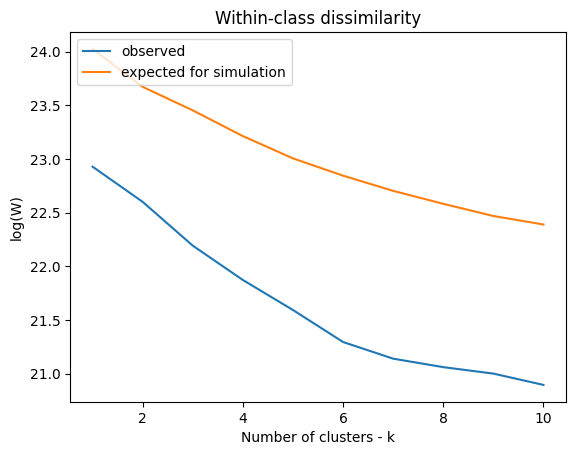

In [5]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

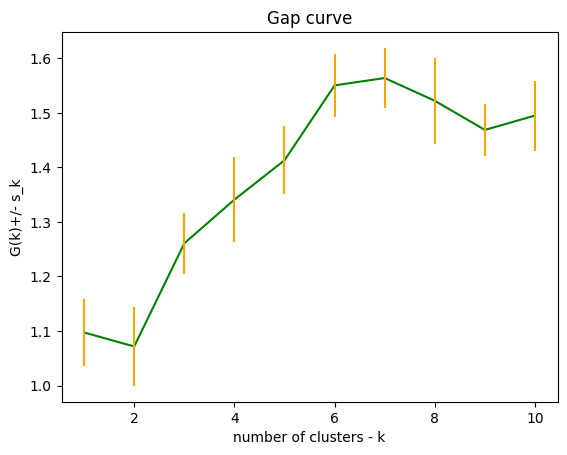

In [6]:
# plot the Gap curve
plt.figure()
plt.title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
plt.plot(x_range,Gk,color='green')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
plt.plot(x_range_list, GkList, color='orange')
plt.ylabel('G(k)+/- s_k')
plt.xlabel('number of clusters - k')
plt.show()

### How are the groups based on the emotions?

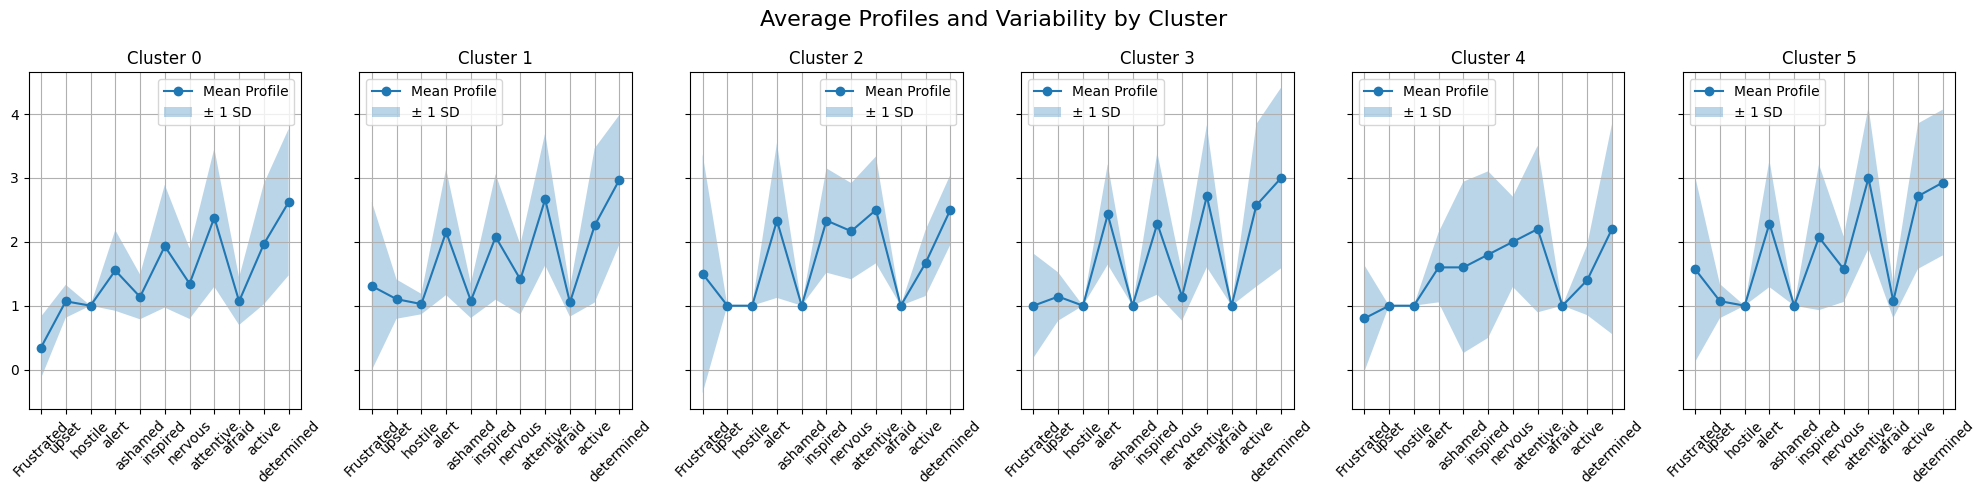

In [23]:
# Assuming your df_emotions is already defined and preprocessed
df_phase1 = df[df['Phase'] == 'phase1']
df_phase1 = df_phase1.dropna()
df_phys = df_phase1[phys_var_columns]


# If df_emotions is a numpy array, convert it to DataFrame
df_phys = pd.DataFrame(df_phys, columns=phys_var_columns)

df_phase1_IDs = df[df['Phase'] == 'phase1']
df_phase1_IDs = df_phase1_IDs.dropna()
columns = [ "Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]
df_phase1_IDs = df_phase1_IDs[columns]

# 2. Perform KMeans clustering
df_phys = df_phys.dropna()
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_phys)
labels = kmeans.labels_

# 3. Create a DataFrame to hold the cluster assignments
df_phase1_IDs = df_phase1_IDs.copy()
df_phase1_IDs['Cluster'] = labels

# 4. Prepare for plotting
n_clusters = 6
fig, axs = plt.subplots(1, n_clusters, figsize=(20, 5), sharey=True)

for cluster_id in range(n_clusters):
    cluster_data = df_phase1_IDs[df_phase1_IDs['Cluster'] == cluster_id]
    
    # Compute mean and standard deviation for this cluster
    mean_profile = cluster_data.iloc[:, :-1].mean()  # exclude 'Cluster' column
    std_profile = cluster_data.iloc[:, :-1].std()
    
    x = np.arange(len(columns))
    
    # Plot
    axs[cluster_id].plot(x, mean_profile, marker='o', label='Mean Profile')
    axs[cluster_id].fill_between(x, mean_profile - std_profile, mean_profile + std_profile, alpha=0.3, label='± 1 SD')
    
    axs[cluster_id].set_title(f'Cluster {cluster_id}')
    axs[cluster_id].set_xticks(x)
    axs[cluster_id].set_xticklabels(columns, rotation=45)
    axs[cluster_id].grid(True)
    axs[cluster_id].legend()

fig.suptitle('Average Profiles and Variability by Cluster', fontsize=16)
plt.tight_layout()
plt.show()


### Repeat with the Phase 2 

In [24]:
df_phase2 = df[df['Phase'] == 'phase2']

df_phys = df_phase2[phys_var_columns]

# Remove the NANs

df_phys = df_phys.dropna()

df_phys = np.asarray(df_phys)

minX = list(np.min(df_phys, axis=0)) # data range min
maxX = list(np.max(df_phys, axis=0)) # data range max

[N, p] = df_phys.shape

clustersNr = 10
list_of_clusters = range(1,clustersNr+1)
Nsim = 20
W = np.zeros(clustersNr)
Wu = np.zeros((clustersNr, Nsim))
for nrClusters in list_of_clusters: # Want actual number included
    kmeans = KMeans(n_clusters=nrClusters).fit(df_phys)
    C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
    labelCluster = kmeans.labels_ # the labelling for each point
    
    # Compute within-class dissimilarity given X (the data), C (the cluster centers)
    # and gr (the predicted cluster numbers)
    for cluster in range(1, nrClusters + 1):
        Ik = np.where(labelCluster == cluster - 1)[0]
        dk = np.sum((df_phys[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[nrClusters-1] += Dk
    
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        # perform K-means
        kmeansU = KMeans(n_clusters=nrClusters).fit(Xu)
        Cu = kmeansU.cluster_centers_
        labelClusterU = kmeansU.labels_

        # Compute within-class dissmiliarity for the simulated data given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and gru (the predicted cluster numbers)
        # for the simulated data).
        for cluster in range(1, nrClusters+1):
            Iku = np.where(labelClusterU == cluster - 1)
            dku = np.sum((Xu[Iku, :] - np.multiply(np.ones((np.size(Iku), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dku = np.sum(dku)
            Wu[nrClusters - 1, j] += Dku

        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

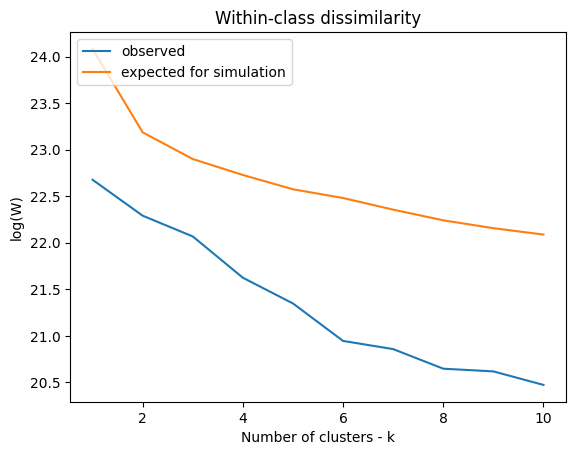

In [25]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

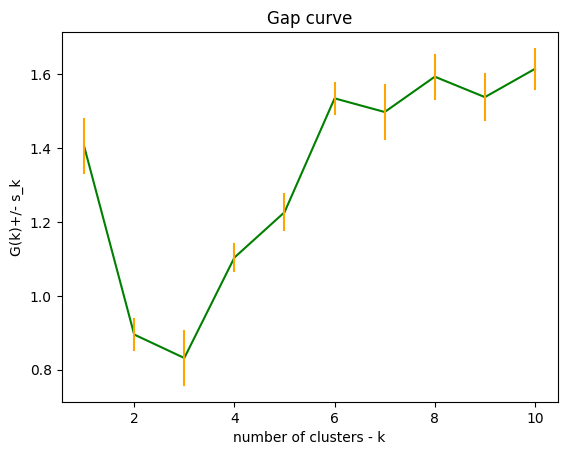

In [26]:
# plot the Gap curve
plt.figure()
plt.title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
plt.plot(x_range,Gk,color='green')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
plt.plot(x_range_list, GkList, color='orange')
plt.ylabel('G(k)+/- s_k')
plt.xlabel('number of clusters - k')
plt.show()

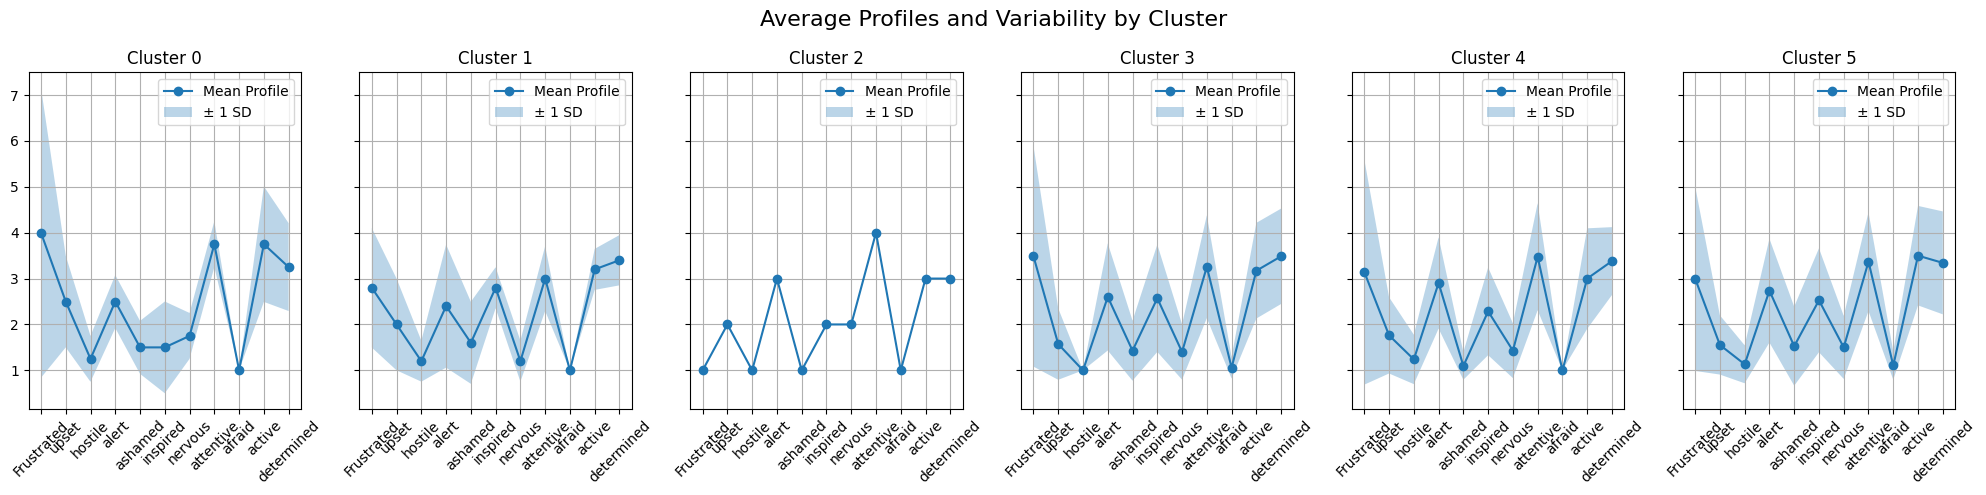

In [32]:
# Assuming your df_emotions is already defined and preprocessed
df_phase2 = df[df['Phase'] == 'phase2']
df_phase2 = df_phase2.dropna()
df_phys = df_phase2[phys_var_columns]


# If df_emotions is a numpy array, convert it to DataFrame
df_phys = pd.DataFrame(df_phys, columns=phys_var_columns)

df_phase2_IDs = df[df['Phase'] == 'phase2']
df_phase2_IDs = df_phase2_IDs.dropna()
columns = [ "Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]
df_phase2_IDs = df_phase2_IDs[columns]

# 2. Perform KMeans clustering
df_phys = df_phys.dropna()
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_phys)
labels = kmeans.labels_

# 3. Create a DataFrame to hold the cluster assignments
df_phase2_IDs = df_phase2_IDs.copy()
df_phase2_IDs['Cluster'] = labels

# 4. Prepare for plotting
n_clusters = 6
fig, axs = plt.subplots(1, n_clusters, figsize=(20, 5), sharey=True)

for cluster_id in range(n_clusters):
    cluster_data = df_phase2_IDs[df_phase2_IDs['Cluster'] == cluster_id]
    
    # Compute mean and standard deviation for this cluster
    mean_profile = cluster_data.iloc[:, :-1].mean()  # exclude 'Cluster' column
    std_profile = cluster_data.iloc[:, :-1].std()
    
    x = np.arange(len(columns))
    
    # Plot
    axs[cluster_id].plot(x, mean_profile, marker='o', label='Mean Profile')
    axs[cluster_id].fill_between(x, mean_profile - std_profile, mean_profile + std_profile, alpha=0.3, label='± 1 SD')
    
    axs[cluster_id].set_title(f'Cluster {cluster_id}')
    axs[cluster_id].set_xticks(x)
    axs[cluster_id].set_xticklabels(columns, rotation=45)
    axs[cluster_id].grid(True)
    axs[cluster_id].legend()

fig.suptitle('Average Profiles and Variability by Cluster', fontsize=16)
plt.tight_layout()
plt.show()

### Repeat for the phase 3

In [33]:
df_phase3 = df[df['Phase'] == 'phase3']

df_phys = df_phase3[phys_var_columns]

# Remove the NANs

df_phys = df_phys.dropna()

df_phys = np.asarray(df_phys)

minX = list(np.min(df_phys, axis=0)) # data range min
maxX = list(np.max(df_phys, axis=0)) # data range max

[N, p] = df_phys.shape

clustersNr = 10
list_of_clusters = range(1,clustersNr+1)
Nsim = 20
W = np.zeros(clustersNr)
Wu = np.zeros((clustersNr, Nsim))
for nrClusters in list_of_clusters: # Want actual number included
    kmeans = KMeans(n_clusters=nrClusters).fit(df_phys)
    C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
    labelCluster = kmeans.labels_ # the labelling for each point
    
    # Compute within-class dissimilarity given X (the data), C (the cluster centers)
    # and gr (the predicted cluster numbers)
    for cluster in range(1, nrClusters + 1):
        Ik = np.where(labelCluster == cluster - 1)[0]
        dk = np.sum((df_phys[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[nrClusters-1] += Dk
    
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        # perform K-means
        kmeansU = KMeans(n_clusters=nrClusters).fit(Xu)
        Cu = kmeansU.cluster_centers_
        labelClusterU = kmeansU.labels_

        # Compute within-class dissmiliarity for the simulated data given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and gru (the predicted cluster numbers)
        # for the simulated data).
        for cluster in range(1, nrClusters+1):
            Iku = np.where(labelClusterU == cluster - 1)
            dku = np.sum((Xu[Iku, :] - np.multiply(np.ones((np.size(Iku), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dku = np.sum(dku)
            Wu[nrClusters - 1, j] += Dku

        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

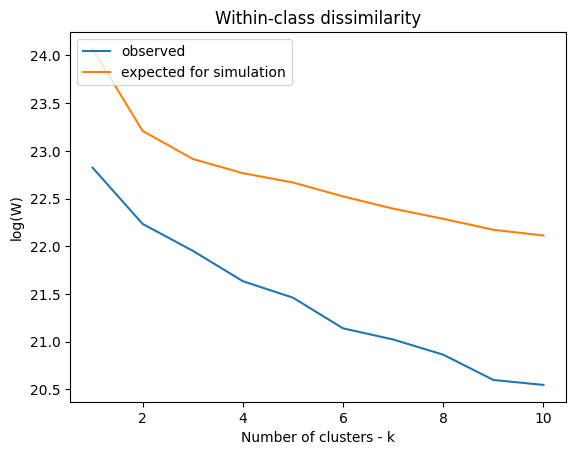

In [34]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

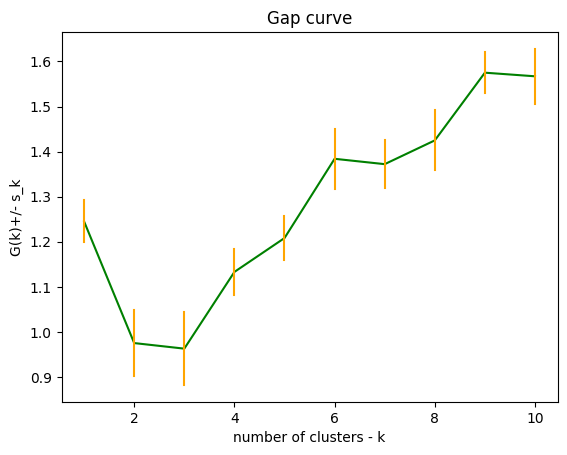

In [35]:
# plot the Gap curve
plt.figure()
plt.title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
plt.plot(x_range,Gk,color='green')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
plt.plot(x_range_list, GkList, color='orange')
plt.ylabel('G(k)+/- s_k')
plt.xlabel('number of clusters - k')
plt.show()

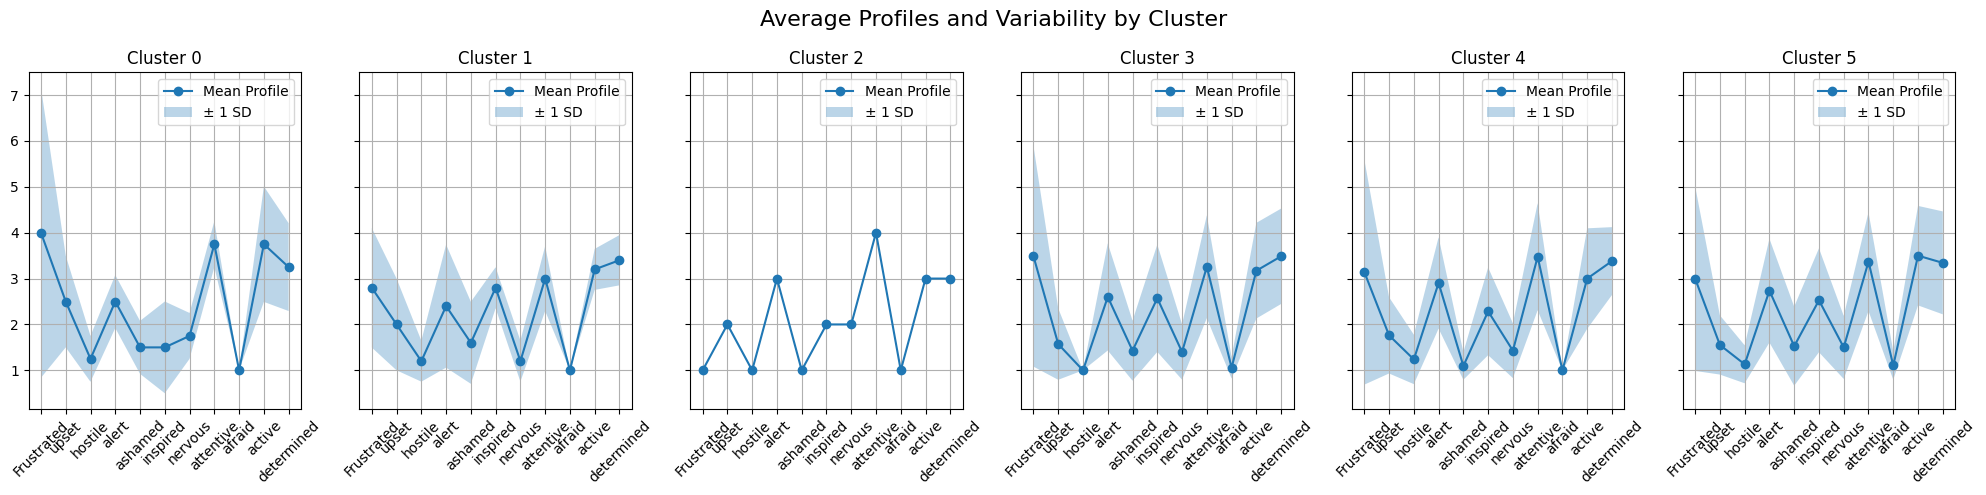

In [36]:
# Assuming your df_emotions is already defined and preprocessed
df_phase3 = df[df['Phase'] == 'phase3']
df_phase3 = df_phase3.dropna()
df_phys = df_phase3[phys_var_columns]


# If df_emotions is a numpy array, convert it to DataFrame
df_phys = pd.DataFrame(df_phys, columns=phys_var_columns)

df_phase3_IDs = df[df['Phase'] == 'phase3']
df_phase3_IDs = df_phase3_IDs.dropna()
columns = [ "Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]
df_phase3_IDs = df_phase3_IDs[columns]

# 2. Perform KMeans clustering
df_phys = df_phys.dropna()
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_phys)
labels = kmeans.labels_

# 3. Create a DataFrame to hold the cluster assignments
df_phase3_IDs = df_phase3_IDs.copy()
df_phase3_IDs['Cluster'] = labels

# 4. Prepare for plotting
n_clusters = 6
fig, axs = plt.subplots(1, n_clusters, figsize=(20, 5), sharey=True)

for cluster_id in range(n_clusters):
    cluster_data = df_phase2_IDs[df_phase2_IDs['Cluster'] == cluster_id]
    
    # Compute mean and standard deviation for this cluster
    mean_profile = cluster_data.iloc[:, :-1].mean()  # exclude 'Cluster' column
    std_profile = cluster_data.iloc[:, :-1].std()
    
    x = np.arange(len(columns))
    
    # Plot
    axs[cluster_id].plot(x, mean_profile, marker='o', label='Mean Profile')
    axs[cluster_id].fill_between(x, mean_profile - std_profile, mean_profile + std_profile, alpha=0.3, label='± 1 SD')
    
    axs[cluster_id].set_title(f'Cluster {cluster_id}')
    axs[cluster_id].set_xticks(x)
    axs[cluster_id].set_xticklabels(columns, rotation=45)
    axs[cluster_id].grid(True)
    axs[cluster_id].legend()

fig.suptitle('Average Profiles and Variability by Cluster', fontsize=16)
plt.tight_layout()
plt.show()

# See changes intra patients

In [103]:
# Load (again) data
df = pd.read_csv('../data/HR_data.csv')

emotions_columns = ["Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]

df_phase1 = df[df['Phase'] == 'phase1']
df_phase2 = df[df['Phase'] == 'phase2']
df_phase3 = df[df['Phase'] == 'phase3']

In [104]:
df_phase1_clean = df_phase1.dropna()
df_emotions1 = df_phase1_clean[emotions_columns]
kmeans1 = KMeans(n_clusters=5, random_state=0).fit(df_emotions1)
df_phase1['cluster_phase1'] = np.nan
df_phase1.loc[df_phase1_clean.index, 'cluster_phase1'] = kmeans1.labels_

df_phase2_clean = df_phase2.dropna()
df_emotions2 = df_phase2_clean[emotions_columns]
kmeans2 = KMeans(n_clusters=6, random_state=0).fit(df_emotions2)
df_phase2['cluster_phase2'] = np.nan
df_phase2.loc[df_phase2_clean.index, 'cluster_phase2'] = kmeans2.labels_

df_phase3_clean = df_phase3.dropna()
df_emotions3 = df_phase3_clean[emotions_columns]
kmeans3 = KMeans(n_clusters=3, random_state=0).fit(df_emotions3)
df_phase3['cluster_phase3'] = np.nan
df_phase3.loc[df_phase3_clean.index, 'cluster_phase3'] = kmeans3.labels_

# First merge phase1 and phase2
df_temp = pd.merge(
    df_phase1[['Individual', 'cluster_phase1', 'Phase']],
    df_phase2[['Individual', 'cluster_phase2', 'Phase']],
    on='Individual',
    how='outer'
)

# Then merge the result with phase3
df_merged = pd.merge(
    df_temp,
    df_phase3[['Individual', 'cluster_phase3', 'Phase']],
    on='Individual',
    how='outer'
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17252\1722841675.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17252\1722841675.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17252\1722841675.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

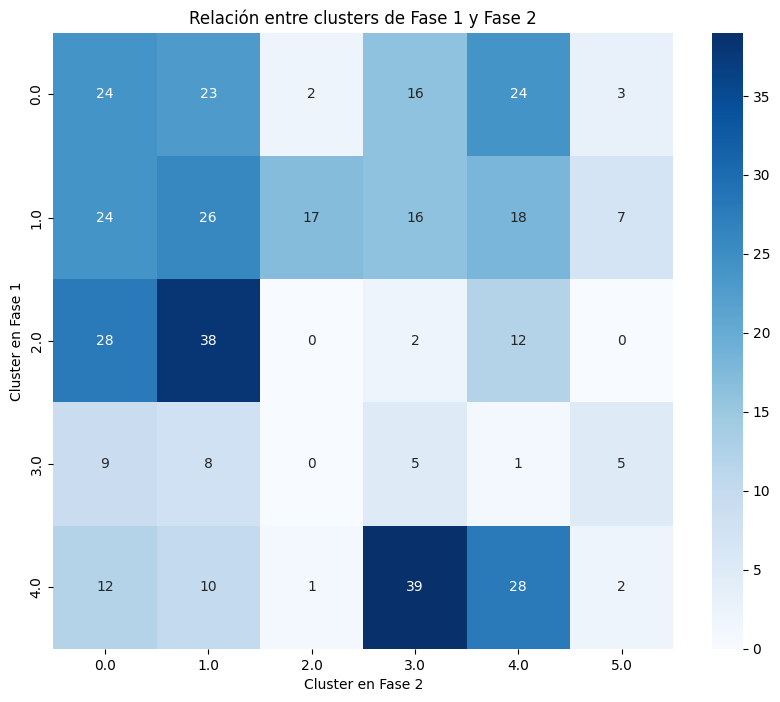

In [81]:
# Suponiendo que tu DataFrame se llama df
# Creamos una tabla de conteos entre cluster de fase1 y fase2
confusion = pd.crosstab(df_merged['cluster_phase1'], df_merged['cluster_phase2'])

# Graficamos
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.title('Relación entre clusters de Fase 1 y Fase 2')
plt.xlabel('Cluster en Fase 2')
plt.ylabel('Cluster en Fase 1')
plt.show()

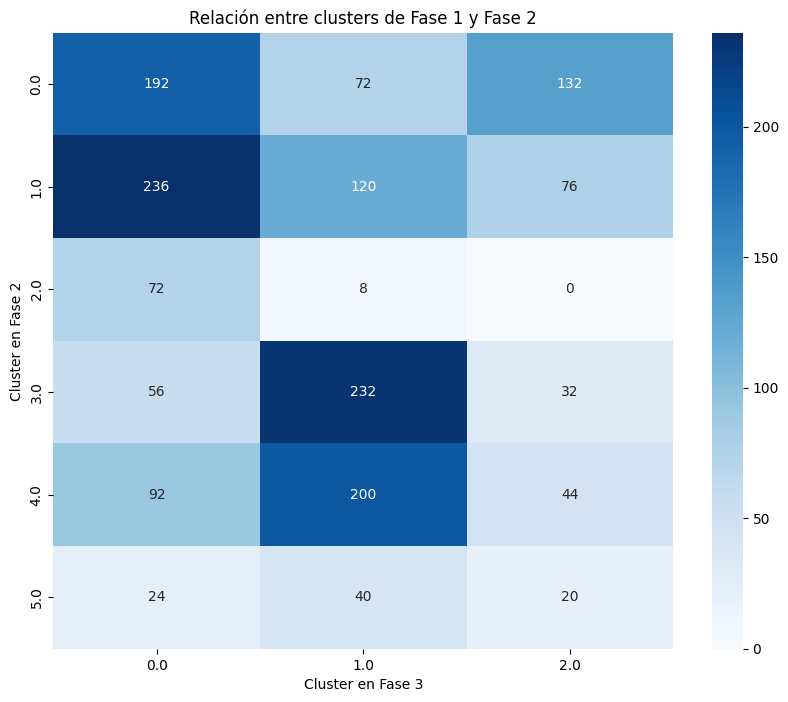

In [109]:
# Suponiendo que tu DataFrame se llama df
# Creamos una tabla de conteos entre cluster de fase1 y fase2
confusion = pd.crosstab(df_merged['cluster_phase2'], df_merged['cluster_phase3'])

# Graficamos
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.title('Relación entre clusters de Fase 1 y Fase 2')
plt.xlabel('Cluster en Fase 3')
plt.ylabel('Cluster en Fase 2')
plt.show()

In [106]:
import plotly.graph_objects as go

df = df_merged

# Primero contamos las transiciones entre fase 1 -> fase 2
transitions_12 = df.groupby(['cluster_phase1', 'cluster_phase2']).size().reset_index(name='count')

# Luego contamos las transiciones entre fase 2 -> fase 3
transitions_23 = df.groupby(['cluster_phase2', 'cluster_phase3']).size().reset_index(name='count')

# Crear las listas necesarias para el Sankey
max_phase1 = int(df['cluster_phase1'].max()) + 1
max_phase2 = int(df['cluster_phase2'].max()) + 1

# Para fase1 -> fase2
source_12 = transitions_12['cluster_phase1'].astype(int)
target_12 = transitions_12['cluster_phase2'].astype(int) + max_phase1  # desplazamos para no solaparlos
value_12 = transitions_12['count']

# Para fase2 -> fase3
source_23 = transitions_23['cluster_phase2'].astype(int) + max_phase1
target_23 = transitions_23['cluster_phase3'].astype(int) + max_phase1 + max_phase2
value_23 = transitions_23['count']

# Unimos todo
source = pd.concat([source_12, source_23])
target = pd.concat([target_12, target_23])
values = pd.concat([value_12, value_23])

# Crear las etiquetas
labels = (
    [f'Fase1 Cluster {i}' for i in sorted(df['cluster_phase1'].dropna().unique())] +
    [f'Fase2 Cluster {i}' for i in sorted(df['cluster_phase2'].dropna().unique())] +
    [f'Fase3 Cluster {i}' for i in sorted(df['cluster_phase3'].dropna().unique())]
)

# Crear el diagrama de Sankey
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels
    ),
    link = dict(
      source = source,
      target = target,
      value = values
    ))])

fig.update_layout(title_text="Flujo de Pacientes entre Clusters Fase 1, Fase 2 y Fase 3", font_size=10)
fig.show()
